In [90]:
import os


def get_gesture_list() -> list[str]:
    folder_path = "./savedata"
    if not os.path.exists(folder_path) or not os.listdir(folder_path):
        return []
    else:
        return [
            name
            for name in os.listdir(folder_path)
            if os.path.isdir(os.path.join(folder_path, name))
        ]


def get_gesture_files(gesture: str) -> list[str]:
    folder_path = f"./savedata/{gesture}"
    if not os.path.exists(folder_path) or not os.listdir(folder_path):
        return []
    else:
        return [
            name
            for name in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, name))
        ]

In [91]:
from typing import List

import pandas as pd


# Load data
data: dict[str, List[pd.DataFrame]] = {}
gestures = get_gesture_list()
for gesture in gestures:
    data[gesture] = []  # Initialize the list for each gesture
    gesture_files = get_gesture_files(gesture)
    for index, gesture_file in enumerate(gesture_files):
        # print(f"{gesture = }, {index = }")
        df = pd.read_csv(f"./savedata/{gesture}/{gesture_file}")

        # Drop column 'Time' if found
        df = df.drop("Time", axis=1, errors="ignore")

        data[gesture].append(df)

In [92]:
# Explore the data
data1 = data[gestures[0]][0]
data1.head()

,aX,aY,aZ,gX,gY,gZ
0,-0.070,-0.342,-0.936,-0.14,-0.28,-0.14
1,-0.069,-0.342,-0.935,-0.14,-0.35,-0.14
2,-0.071,-0.343,-0.934,-0.28,-0.35,-0.07
3,-0.071,-0.342,-0.935,-0.28,-0.35,-0.07
4,-0.071,-0.343,-0.936,-0.28,-0.35,-0.07


In [93]:
# Explore the data
data1.describe()

,aX,aY,aZ,gX,gY,gZ
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,-0.070475,-0.342417,-0.935033,-0.207667,-0.323750,-0.075833
std,0.000799,0.001112,0.001276,0.080113,0.072065,0.034655
min,-0.072000,-0.345000,-0.938000,-0.420000,-0.490000,-0.140000
25%,-0.071000,-0.343000,-0.936000,-0.280000,-0.350000,-0.070000
50%,-0.071000,-0.342000,-0.935000,-0.210000,-0.350000,-0.070000
75%,-0.070000,-0.342000,-0.934000,-0.140000,-0.280000,-0.070000
max,-0.068000,-0.340000,-0.932000,0.000000,-0.140000,0.000000


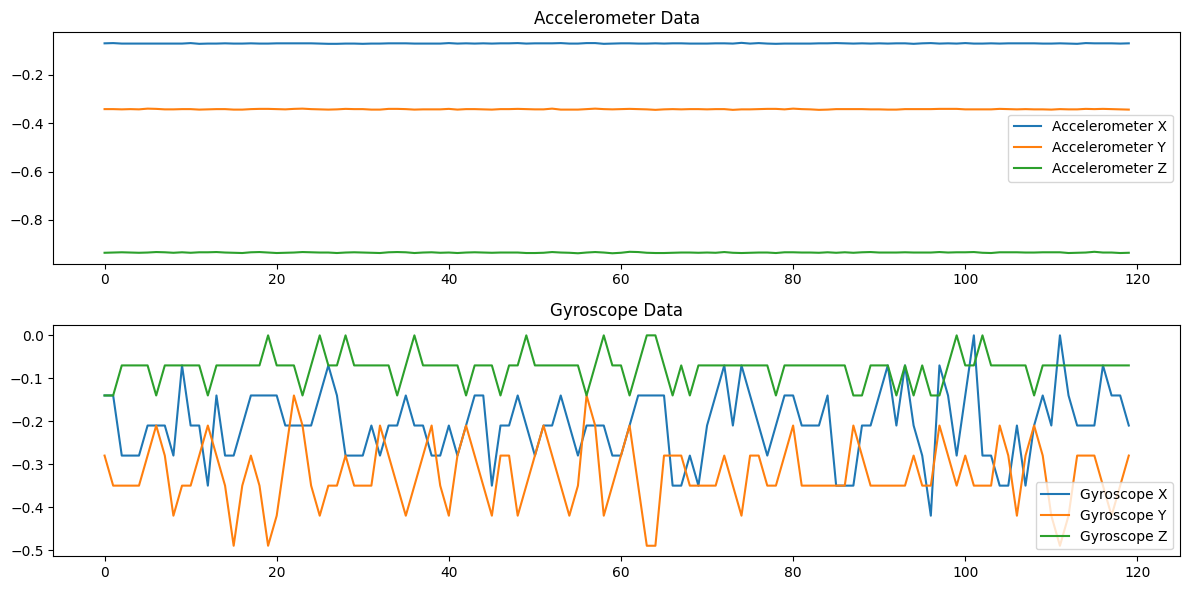

In [94]:
# Visualize the sensor data
from matplotlib import pyplot as plt


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data1["aX"], label="Accelerometer X")
plt.plot(data1["aY"], label="Accelerometer Y")
plt.plot(data1["aZ"], label="Accelerometer Z")
plt.title("Accelerometer Data")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data1["gX"], label="Gyroscope X")
plt.plot(data1["gY"], label="Gyroscope Y")
plt.plot(data1["gZ"], label="Gyroscope Z")
plt.title("Gyroscope Data")
plt.legend()
plt.tight_layout()

plt.show()

In [95]:
# Import necessary libraries
import numpy as np
import tf_keras as keras
from sklearn.model_selection import train_test_split

# Assuming your data is in the following format
# data: dict[str, List[pd.DataFrame]]
# The str field is the "gesture"
# The List[pd.DataFrame] is the data "points"


# Prepare the data
def prepare_data(data):
    X = []
    y = []
    gestures = list(data.keys())
    for gesture in gestures:
        for df in data[gesture]:
            X.append(df.values)
            y.append(gestures.index(gesture))
    X = np.array(X)
    y = keras.utils.to_categorical(y, num_classes=len(gestures))
    return X, y


# Load your data
# data = ... (Data already loaded)

# Prepare the data
X, y = prepare_data(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(120, 6)))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(48, activation="relu"))
model.add(keras.layers.Dense(48, activation="relu"))
model.add(keras.layers.Dense(48, activation="relu"))
model.add(keras.layers.Dense(48, activation="relu"))
model.add(keras.layers.Dense(48, activation="relu"))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(len(data.keys()), activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Show the model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 720)               0         
                                                                 
 dense_80 (Dense)            (None, 32)                23072     
                                                                 
 dense_81 (Dense)            (None, 48)                1584      
                                                                 
 dense_82 (Dense)            (None, 48)                2352      
                                                                 
 dense_83 (Dense)            (None, 48)                2352      
                                                                 
 dense_84 (Dense)            (None, 48)                2352      
                                                                 
 dense_85 (Dense)            (None, 48)              

In [96]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/20
8/8 [==============================] - 3s 59ms/step - loss: 3.9531 - accuracy: 0.3473 - val_loss: 1.9540 - val_accuracy: 0.3333
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.9104 - accuracy: 0.5272 - val_loss: 1.0198 - val_accuracy: 0.6333
Epoch 3/20
8/8 [==============================] - 0s 9ms/step - loss: 0.5934 - accuracy: 0.7364 - val_loss: 0.7242 - val_accuracy: 0.7333
Epoch 4/20
8/8 [==============================] - 0s 11ms/step - loss: 0.4836 - accuracy: 0.8494 - val_loss: 0.6350 - val_accuracy: 0.7667
Epoch 5/20
8/8 [==============================] - 0s 11ms/step - loss: 0.4033 - accuracy: 0.9289 - val_loss: 0.5940 - val_accuracy: 0.8500
Epoch 6/20
8/8 [==============================] - 0s 10ms/step - loss: 0.3483 - accuracy: 0.9833 - val_loss: 0.6157 - val_accuracy: 0.8667
Epoch 7/20
8/8 [==============================] - 0s 10ms/step - loss: 0.2990 - accuracy: 1.0000 - val_loss: 0.6141 - val_accuracy: 0.9000
Epoch 8/20
8/8 [=============

In [97]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix: ")
print(cm)

2/2 [==============================] - 0s 3ms/step
Confusion Matrix: 
[[28  1  0]
 [ 0  8  0]
 [ 1  0 22]]


In [98]:
# Convert the model to TFLite format
import tensorflow as tf


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()



# Save the TFLite model to a file
os.makedirs(f"./model", exist_ok=True)
with open('./model/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Convert the TFLite model to a C array
def convert_tflite_to_c_array(tflite_model, bytes_per_line=16):
    c_array = ''
    for i in range(0, len(tflite_model), bytes_per_line):
        line = ', '.join(f'0x{byte:02x}' for byte in tflite_model[i:i+bytes_per_line])
        c_array += '    ' + line + ',\n'
    
    c_usual_herder = '#pragma once'
    gesture_len_str = f'const unsigned int gesture_len = {len(gestures)};'
    gesture_str = f'const char *gestures[{len(gestures)}] = {{{', '.join(f'"{gesture}"' for gesture in gestures)}}};'
    param_count_str = f'const unsigned int model_parameters = {model.count_params()};'
    model_len_str = f'const unsigned int model_data_len = {len(tflite_model)};'
    model_str = f'const unsigned char model_data[{len(tflite_model)}] PROGMEM = {{\n{c_array}}};'
    
    return f'{c_usual_herder}\n\n{gesture_len_str}\n\n{gesture_str}\n\n{param_count_str}\n\n{model_len_str}\n\n{model_str}\n'

# Save the C array to a header file
c_array_str = convert_tflite_to_c_array(tflite_model)
with open('./model/model.h', 'w') as f:
    f.write(c_array_str)

INFO:tensorflow:Assets written to: C:\Users\KaiZen42\AppData\Local\Temp\tmpohr3k5t6\assets


INFO:tensorflow:Assets written to: C:\Users\KaiZen42\AppData\Local\Temp\tmpohr3k5t6\assets
